# **Introduction**

In this notebook, we will demonstrate how to set up a minimal Particle-In-Cell (PIC) plasma simulation using the `PlasmaTorch` framework. Our goal is to:

1. Initialize a simulation domain.
2. Create a uniform distribution of charged particles.
3. Run a single simulation step to solve for the electrostatic potential via Poisson's equation.
4. Show how data can be collected for post-processing (e.g., positions, velocities, fields, and energies).

Since our focus here is on demonstrating the workflow rather than running a long simulation, we will use a very short simulation time and only one update step. This will allow us to highlight how to use the Poisson solver and how to extract basic simulation data.

## Step 1: Load Libraries and Configure the Environment

We begin by importing the necessary Python libraries and modules from `PlasmaTorch`. Finally, we detect the available device (`CPU` or `GPU`) and fix a random seed for reproducibility.

In [21]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import torch.autograd.profiler as profiler
from scipy.constants import *
import time

import sys
sys.path.append("../")
sys.path.append("../plasmatorch")

from plasmatorch.simulator import *
from plasmatorch.utils import *
from plasmatorch.deposition import *
from plasmatorch.fields import *
from plasmatorch.helper import *

device = "cuda" if torch.cuda.is_available() else "cpu"
set_seed(2304)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 2: Define Simulation Domain and Instantiate the PIC Simulator

In this step, we:

1. Specify the domain size (`Lx` and `Ly`) and the number of grid points (`Nx` and `Ny`).
2. Choose a time step (`dt`) and an overall simulation time (`simulation_time`). In this example, we use a very short simulation time.
3. Create an instance of `PlasmaTorch` with periodic boundary conditions (`boundaries_type="periodic"`). The `save_frequency` determines how often data is recorded.

With these settings, the main purpose is to solve Poisson's equation for a uniform distribution of charges.

In [22]:
Lx, Ly = 1.0, 1.0
Nx, Ny = 32, 32
simulation_time = 1e-5  # short time, mainly to solve Poisson
dt = 1e-5
simulation_name = "Test"
backend = device

# Instantiate the simulation space
sim = PlasmaTorch(
    simulation_name=simulation_name,
    Lx=Lx,
    Ly=Ly,
    Nx=Nx,
    Ny=Ny,
    simulation_time=simulation_time,
    dt=dt,
    boundaries_type="periodic",  # Not very important for just solving Poisson
    save_frequency=1,
    backend=backend
)

## Step 3: Initialize a Uniform Charge Distribution

We create a particle species named `A` with 10,000 particles. These particles are assigned:

- A mass of 1.0
- A charge of +1.0
- Random initial positions within the domain (`disposition="random"`)

This ensures that our domain has some non-zero charge density, which will drive the Poisson solver.

In [23]:
# Create a particle species to generate a uniform charge density
# Alternatively, one could directly deposit charge onto the grid,
# but we use built-in functions for consistency with the PIC code
num_particles = 10_000
sim.create_new_specie(
    name="A",
    num_particles=num_particles,
    distribution="zero",
    disposition="random",
    mass=1,
    charge=1,
)

## Step 4: Run One Simulation Update and Inspect the Potential

We now run a single update step (`sim.update()`), which involves the following:

1. Depositing the charge density from particles onto the grid.
2. Solving Poisson's equation for the electrostatic potential.
3. Computing and storing relevant field and particle updates.

Afterward, we extract the potential data from the grid (in particular, the second channel `[:, :, 1]`) and print a small portion of it to confirm that the solver has run.

In [24]:
# Perform one step to solve Poisson
sim.update()

# Observe the potential
potential = sim.grid[:, :, 1].cpu().numpy()
print("Potential solved by Poisson equation (3 values extracted):")
print(potential.ravel()[34:37])

Potential solved by Poisson equation (3 values extracted):
[3.8545945e+12 5.0054992e+12 6.0514406e+12]


## Step 5: Retrieve Chronological Data

In a longer simulation, or if `save_frequency` was higher, we would expect multiple time steps to be recorded. We could then stack position, velocity, and field data to analyze or visualize the evolution.

In a practical scenario, you would run more steps (e.g., thousands of steps), ensure data saving is enabled, and then visualize the results by stacking and plotting the chronological data.

[INFO] Loaded datasets from Test: ['charge_register', 'fields_chronology', 'fixed_potential_mask', 'fixed_potential_value', 'grid_chronology', 'kinetic_energy_chronology', 'mass_register', 'mechanic_energy_chronology', 'particles_active_chronology', 'particles_position_chronology', 'particles_specie_chronology', 'particles_velocity_chronology', 'potential_energy_chronology', 'solid_mask', 'solid_type']


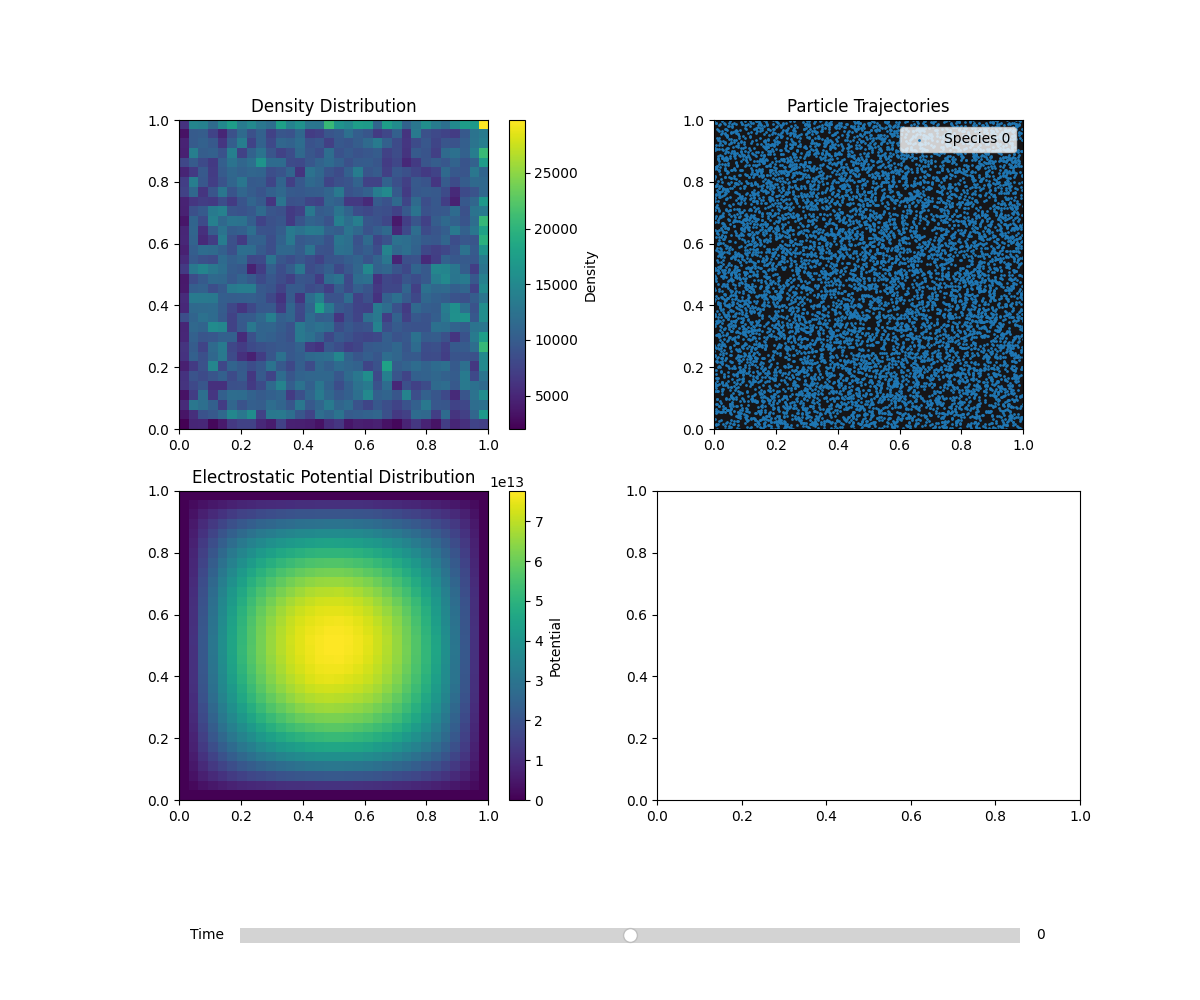

In [25]:
simulation = load_simulation(simulation_name, device= backend)

%matplotlib widget
dynamic_slider(simulation, Lx, Ly)